<a href="https://www.kaggle.com/code/sudoshivam/dcgan-anime?scriptVersionId=118874182" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
# Only run this cell if downgrading Tensorflow is necessary
# Kernel must be restarted after downgrading!
from IPython.display import clear_output

!pip install -q tensorflow==2.4.1

clear_output()

In [1]:
import os
import numpy as np
import cv2
from glob import glob
from matplotlib import pyplot
from PIL import Image
from sklearn.utils import shuffle
import tensorflow as tf 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

2023-02-11 14:45:37.825847: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
print(tf.__version__)

2.4.1


In [3]:
IMG_H = 64
IMG_W = 64
IMG_C = 3

# Weight initializer
w_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

In [4]:
# Hyperparameters
batch_size = 128
latent_dim = 128
num_epochs = 50

In [5]:
# Dataset
image_path = glob("/kaggle/input/anime-faces/data/data/*")
print("Dataset Size: ", len(image_path))

Dataset Size:  21551


(-0.5, 63.5, 63.5, -0.5)

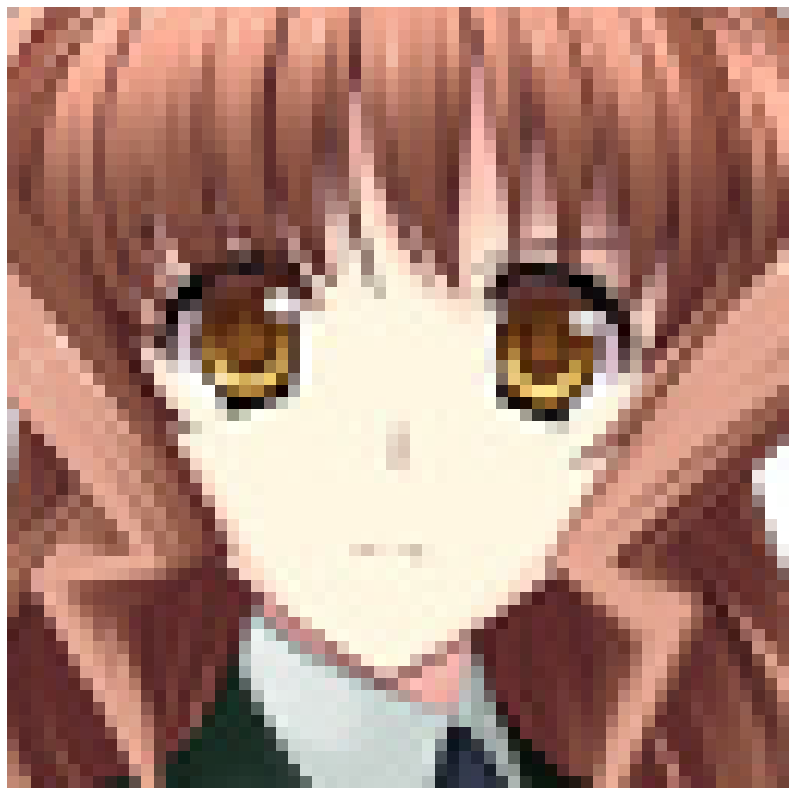

In [8]:
# Plot an image from dataset
img1 = Image.open("/kaggle/input/anime-faces/data/data/100.png")
f = pyplot.figure(figsize=(14, 16))

pyplot.imshow(img1)
pyplot.axis('off')

In [9]:
# Image preprocessing
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image)
    image = tf.image.resize(image, (IMG_H, IMG_W))
    image = tf.cast(image, tf.float32)
    image = (image - 127.5)/127.5
    return image

In [10]:
# Dataset Pipeline
def tf_dataset(image_path, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(image_path)
    datset = dataset.shuffle(buffer_size=1024)
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [11]:
# Generator and Discriminator

# De-convolution Block
def deconv_block(inputs, num_filters, kernel_size, strides, bn=True):
    x = Conv2DTranspose(
        filters=num_filters,
        kernel_size=kernel_size,
        kernel_initializer=w_init,
        padding="same",
        strides=strides,
        use_bias=False
    )(inputs)
    
    if bn:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        
    return x

# Convolution Block
def conv_block(inputs, num_filters, kernel_size, padding="same", strides=2, activation=True):
    x = Conv2D(
        filters=num_filters,
        kernel_size=kernel_size,
        kernel_initializer=w_init,
        padding=padding,
        strides=strides
    )(inputs)
    
    if activation:
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.3)(x)
        
    return x


# building generator
def build_generator(latent_dim):
    f = [2**i for i in range(5)][::-1]
    filters = 32
    output_strides = 16
    h_output = IMG_H // output_strides
    w_output = IMG_W // output_strides
    
    noise = Input(shape=(latent_dim,), name="gen_noise_input")
    
#     initial layer
    x = Dense(f[0] * filters * h_output * w_output, use_bias=False)(noise)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((h_output, w_output, f[0] * filters))(x)
    print(x.shape)
    
#     deconvolutional layer
    for i in range(1, 5):
        x = deconv_block(x,
                        num_filters=f[i] * filters,
                        kernel_size=5,
                        strides=2,
                        bn=True
                        )

#      convolutional layer
    x = conv_block(x,
                  num_filters=3,
                  kernel_size=5,
                  strides=1,
                  activation=False
                  )
    fake_output = Activation("tanh")(x)
    
    return Model(noise, fake_output, name="generator")


# building discriminator
def build_discriminator():
    f = [2**i for i in range(4)]
    filters = 62
    output_strides = 16
    h_output = IMG_H // output_strides
    w_output = IMG_W // output_strides
    
    image_input = Input(shape=(IMG_H, IMG_W, IMG_C), name="images")
    x = image_input
    
    for i in range(0, 4):
        x = conv_block(x,
                      num_filters=f[i] * filters,
                      kernel_size=5,
                      strides=2
                      )
        
    x = Flatten()(x)
    x = Dense(1)(x) # Gives one output: 0 = fake, 1 = real
    
    return Model(image_input, x, name="discriminator")

In [12]:
# create discriminator and generator models
d_model = build_discriminator()
g_model = build_generator(latent_dim)

d_model.summary()
g_model.summary()

2023-02-11 14:47:41.722663: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-11 14:47:41.724519: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-02-11 14:47:41.847807: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-11 14:47:41.848846: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2023-02-11 14:47:41.849076: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-1

(None, 4, 4, 512)
Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images (InputLayer)          [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 62)        4712      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 62)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 62)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 124)       192324    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 124)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None,

In [13]:
# Build GAN Class

class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
            
# training discriminator
# discriminator will be trained twice of generator
        for _ in range(2):
#             fake images
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            generated_images = self.generator(random_latent_vectors)
            generated_labels = tf.zeros((batch_size, 1))
            
            with tf.GradientTape() as ftape:
                predictions = self.discriminator(generated_images)
                d1_loss = self.loss_fn(generated_labels, predictions)
            grads = ftape.gradient(d1_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
            
#             real images
            labels = tf.ones((batch_size, 1))
            with tf.GradientTape() as rtape:
                predictions = self.discriminator(real_images)
                d2_loss = self.loss_fn(labels, predictions)
            grads = rtape.gradient(d2_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
            
# training generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.ones((batch_size, 1))
        
        with tf.GradientTape() as gtape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = gtape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        
        return {"d1_loss": d1_loss, "d2_loss": d2_loss, "g_loss": g_loss}

In [14]:
# function for plotting samples
def save_plot(examples, epoch, n):
    examples = (examples + 1)/2.0
    for i in range(n * n):
        pyplot.subplot(n, n, i+1)
        pyplot.axis("off")
        pyplot.imshow(examples[i])
    filename = f"fake_image_epoch_{epoch+1}.png"
    pyplot.savefig(filename)
    pyplot.close()

In [15]:
# compile GAN model
gan = GAN(d_model, g_model, latent_dim)

bce_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1)
d_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
g_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
gan.compile(d_optimizer, g_optimizer, bce_loss_fn)

In [16]:
images_dataset = tf_dataset(image_path, batch_size)

for epoch in range(num_epochs):
    gan.fit(images_dataset, epochs=1)
    g_model.save("g_model.h5")
    d_model.save("d_model.h5")
    
    n_samples = 25
    noise = np.random.normal(size=(n_samples, latent_dim))
    examples = g_model.predict(noise)
#     save the samples
    save_plot(examples, epoch, int(np.sqrt(n_samples)))

2023-02-11 14:48:30.238534: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-02-11 14:48:30.239441: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000150000 Hz
2023-02-11 14:48:32.792085: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-02-11 14:48:34.692743: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2023-02-11 14:48:34.745860: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


126/169 [=====================>........] - ETA: 17s - d1_loss: 0.2222 - d2_loss: 0.2208 - g_loss: 3.0090

KeyboardInterrupt: 

In [ ]:
# Plot Fake Images
img1 = Image.open("/kaggle/working/fake_image_epoch_1.png") # epoch 1
img10 = Image.open("/kaggle/working/fake_image_epoch_10.png") # epoch10
img20 = Image.open("/kaggle/working/fake_image_epoch_20.png") # epoch 20
img50 = Image.open("/kaggle/working/fake_image_epoch_50.png") # epoch 50 
f = plt.figure(figsize=(18, 24))

f.add_subplot(1,2, 1)
plt.title("epoch_20", loc = 'center')
plt.imshow(img20)
plt.axis('off')
plt.axis("tight")
plt.axis("image")

f.add_subplot(1,2, 2) 
plt.title("epoch_50", loc = 'center')
plt.imshow(img50)
plt.axis('off')
plt.axis("tight")
plt.axis("image")

f.add_subplot(2,2, 1)
plt.title("epoch_1", loc = 'center')
plt.imshow(img1)
plt.axis('off')
plt.axis('tight')
plt.axis("image")

f.add_subplot(2,2, 2)
plt.title("epoch_10", loc = 'center')
plt.imshow(img10)
plt.axis('off')
plt.axis("tight")
plt.axis("image")

plt.show(block=True)

In [ ]:
# Use the trained generator model to create new images
def save_new (examples, n):
    examples = (examples + 1)/2.0
    for i in range(n * n):
        pyplot.subplot(n, n, i+1)
        pyplot.axis("off")
        pyplot.imshow(examples[i])
    filename = f"fake_image.png"
    pyplot.savefig(filename)
    pyplot.close()
    
model = load_model("g_model.h5")
n_samples = 25
latent_dim = 128
latent_points = np.random.normal(size=(n_samples, latent_dim))
examples = model.predict(latent_points)
save_new(examples, 5)

In [ ]:
# Plot new image created by generator
img1 = Image.open("/kaggle/working/fake_image.png")
f = pyplot.figure(figsize=(16, 20))

pyplot.imshow(img20)
pyplot.axis('off')